 # Chapter 15 - Processing sequences using RNNs and CNNs

 ## Forecasting a time series
 Batch of time series (3D array):

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from timeseries.generate import generate_time_series

n_steps_ahead = 50
total_steps = 200
batch_size = 1000
series = generate_time_series(batch_size, total_steps + n_steps_ahead)
print(series.shape)

(1000, 250, 1)


 The two first series of the batch:

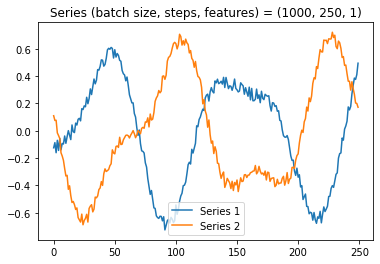

In [2]:

_ = plt.plot(series[0], label="Series 1")
_ = plt.plot(series[1], label="Series 2")
plt.title(f"Series (batch size, steps, features) = {series.shape}")
plt.legend()
plt.show()

 ### Splitting the data
 We aim to predict the number of steps ahead defined by `n_steps_ahead`. First, we define train, validation, and test sets based on the time series batches:

In [3]:
from sklearn.model_selection import train_test_split

def get_train_val_test_split(X, Y, train_val_test_split=(.6,.2,.2)):

    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y,
        test_size=train_val_test_split[2],
        random_state=42)

    X_train, X_valid, Y_train, Y_valid = train_test_split(
        X_train, Y_train,
        train_size=train_val_test_split[0],
        random_state=42)

    return (X_train, X_valid, X_test,
            Y_train, Y_valid, Y_test)


(X_train, X_valid, X_test,
 Y_train, Y_valid, Y_test) = get_train_val_test_split(
    series[:, :total_steps],
    series[:, total_steps:],
    train_val_test_split=(.6,.2,.2))

## Baseline metrics

### Linear regression

Each prediction is a combination of all previous time steps.

In [4]:
from tensorflow import keras

lin_model = keras.models.Sequential([
    keras.layers.Flatten(
        input_shape=[total_steps, 1]),
    keras.layers.Dense(n_steps_ahead)
])

lin_model.summary()

lin_model.compile(loss="mean_squared_error")

lin_model.fit(
    X_train, Y_train,
    epochs=20,
    validation_data=(X_valid, Y_valid)
)

y_linear = lin_model.predict(X_test)

print("RMSE Linear:", np.mean(np.sqrt(
    keras.losses.mean_squared_error(
    y_linear[...,np.newaxis],
    Y_test))))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                10050     
Total params: 10,050
Trainable params: 10,050
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
15/15 [==============================] - 1s 13ms/step - loss: 0.1835 - val_loss: 0.1194
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 0.0910 - val_loss: 0.0830
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 0.0694 - val_loss: 0.0671
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 0.0583 - val_loss: 0.0579
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 0.0514 - val_loss: 0.0535
Epoch 6/20
15/15 [=====

## Option 1: Predict the next step several times in a row

In [5]:
from tensorflow import keras

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.summary()

model.compile(loss="mean_squared_error")

# Fit the model using only the prediction of the next time step
model.fit(
    X_train, Y_train[:, 0],
    epochs=20,
    validation_data=(X_valid, Y_valid[:, 0])
)

y_pred = model.predict(X_test)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, None, 20)          440       
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 20)                820       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
15/15 [==============================] - 4s 183ms/step - loss: 0.0363 - val_loss: 0.0206
Epoch 2/20
15/15 [==============================] - 2s 159ms/step - loss: 0.0142 - val_loss: 0.0101
Epoch 3/20
15/15 [==============================] - 2s 157ms/step - loss: 0.0099 - val_loss: 0.0142
Epoch 4/20
15/15 [==============================] - 2s 158ms/step - loss: 0.0063 -

In [6]:
X = X_test.copy()

# At each iteration, add the predicted value to the input
for step_ahead in range(n_steps_ahead):
    # Increase lenght of time series to account for predicted value
    y_pred_one = model.predict(X[:, step_ahead:])
    # Join predicted value to X
    X = np.concatenate([X, y_pred_one[:, np.newaxis]], axis=1)

Y_rnn_plus_next = X[:, -n_steps_ahead:]

print("RMSE (iterative multistep):", np.mean(np.sqrt(keras.losses.mean_squared_error(
    Y_rnn_plus_next,
    Y_test))))

RMSE (iterative multistep): 0.517167


 ## Option 2: Predict all next values at once
 Sequence-to-vector RNN: output a vector with next `n_steps_ahead` values at the last time step, i.e., after the complete sequence:

In [7]:
rnn_s2v_model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(n_steps_ahead)
])

rnn_s2v_model.summary()

rnn_s2v_model.compile(loss="mean_squared_error")

rnn_s2v_model.fit(
    X_train, Y_train,
    epochs=20,
    validation_data=(X_valid, Y_valid)
)

Y_s2v = rnn_s2v_model.predict(X_test)

print(
    "RMSE s2v RNN:",
    np.mean(np.sqrt(keras.losses.mean_squared_error(
        Y_s2v[...,np.newaxis],
        Y_test)))
)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, None, 20)          440       
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 20)                820       
_________________________________________________________________
dense_2 (Dense)              (None, 50)                1050      
Total params: 2,310
Trainable params: 2,310
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
15/15 [==============================] - 6s 212ms/step - loss: 0.1699 - val_loss: 0.1411
Epoch 2/20
15/15 [==============================] - 3s 184ms/step - loss: 0.1293 - val_loss: 0.1217
Epoch 3/20
15/15 [==============================] - 3s 179ms/step - loss: 0.1110 - val_loss: 0.1012
Epoch 4/20
15/15 [==============================] - 3s 187ms/step - loss: 0.0934 -

 ## Option 3: Sequence-to-sequence RNN

 Sequence-to-sequence RNN: output a vector with next  `n_steps_ahead` values at each time step.

 Advantages of S2S over S2V:
 - Many more error gradients flowing through the model = +stability & +training speed:
    - S2V: Gradients flow only through time;
    - S2S: Gradients flow through time AND from the output of each time step.
 ### How to adjust the data
 Each target must be a sequence of the same length as the input sequence.
 For example, consider the following univariate time series with 10 time steps and corresponding values:

 |    t     |    v     |
 |:--------:|:--------:|
 |    0     |    1     |
 |    1     |    2     |
 |    2     |    3     |
 |    3     |    4     |
 |    4     |    5     |
 |    5     |    6     |
 |    6     |    7     |
 |    7     |    8     |
 |    8     |    9     |
 |    9     |    10    |


 If the expected number of output time steps is `n_steps_ahead=3`, the training data are framed using an overlapping moving window as follows:

 |    t     |   t-1    |    t     |   t+1    |  t+2     |
 |:--------:|:--------:|:--------:|:--------:|:--------:|
 |    0     |  `NaN`   |    1     |    2     |    3     |
 |    1     |    1     |    2     |    3     |    4     |
 |    2     |    2     |    3     |    4     |    5     |
 |    3     |    3     |    4     |    5     |    6     |
 |    4     |    4     |    5     |    6     |    7     |
 |    5     |    5     |    6     |    7     |    8     |
 |    6     |    6     |    7     |    8     |    9     |
 |    7     |    7     |    8     |    9     |    10    |
 |    8     |    8     |    9     |    10    |  `NaN`   |
 |    9     |    9    |     10    |  `NaN`   |  `NaN`   |

 The rows with `NaN` can be excluded. Then, we have:

       X_train = [1 2 3 4 5 6]
       Y_train = [[2 3 4],
                  [3 4 5],
                  [4 5 6],
                  [5 6 7],
                  [6 7 8],
                  [7 8 9],
                  [8 9 10]]

 Although there are overlapping values between `X_train` and `Y_train`, at each time step, the model only knows about past time steps — it cannot look ahead (*causal* model).


In [8]:
train_batch_size = len(X_train)
v2v_shape = (train_batch_size, total_steps, n_steps_ahead)
Y_multistep = np.zeros(v2v_shape)

In [9]:
# Range start from 1 because we want to start the prediction from
# using the first input at the first time step.
#
# In the example below, it corresponds to X=1 and y=[2 3 4]:
#
# |    t     |   t-1    |    t     |   t+1    |  t+2     |
# |:--------:|:--------:|:--------:|:--------:|:--------:|
# |    0     |  `NaN`   |    1     |    2     |    3     |
# |    1     |    1     |    2     |    3     |    4     |
#
for step_ahead in range(1, n_steps_ahead+1):

    # X and y are stacked to create columns with the moving values
    shifted_col = np.concatenate([
        X_train[:, step_ahead:],
        Y_train[:, :step_ahead]],axis=1)

    # Columns are broadcasted to the multistep array
    Y_multistep[:, :, step_ahead-1:] = shifted_col


In [10]:
print(np.round(Y_multistep[0], 2))
print("First column:")
print(np.round(X_train[0][1:4], 2))
print(np.round(X_train[0][-2:], 2))
print(np.round(Y_train[0][:1], 2))

[[-0.44 -0.44 -0.36 ...  0.42  0.47  0.54]
 [-0.44 -0.36 -0.4  ...  0.47  0.54  0.55]
 [-0.36 -0.4  -0.37 ...  0.54  0.55  0.64]
 ...
 [ 0.39  0.35  0.28 ... -0.24 -0.21 -0.2 ]
 [ 0.35  0.28  0.25 ... -0.21 -0.2  -0.16]
 [ 0.28  0.25  0.25 ... -0.2  -0.16 -0.16]]
First column:
[[-0.44]
 [-0.44]
 [-0.36]]
[[0.39]
 [0.35]]
[[0.28]]


In [11]:
v2v_shape = (batch_size, total_steps, n_steps_ahead)
print("Series:", series.shape)
print(v2v_shape)
Y_multistep = np.zeros(v2v_shape)
print(Y_multistep.shape)

Series: (1000, 250, 1)
(1000, 200, 50)
(1000, 200, 50)


In [12]:
# Range start from 1 because we want to start the prediction from
# using the first input at the first time step.
#
# In the example below, it corresponds to X=1 and y=[2 3 4]:
#
# |    t     |   t-1    |    t     |   t+1    |  t+2     |
# |:--------:|:--------:|:--------:|:--------:|:--------:|
# |    0     |  `NaN`   |    1     |    2     |    3     |
# |    1     |    1     |    2     |    3     |    4     |
#
for step_ahead in range(1, n_steps_ahead+1):
    # X and y are stacked to create columns with the moving values
    shifted_col = series[:, step_ahead: step_ahead + total_steps, :]
    # Columns are broadcasted to the multistep array
    Y_multistep[:, :, step_ahead-1:] = shifted_col

X_train_s2s, X_valid_s2s, X_test_s2s, Y_train_s2s, Y_valid_s2s, Y_test_s2s = get_train_val_test_split(
    series[:, :total_steps, :], Y_multistep)

In [13]:
# To turn the model into a sequence-to-sequence model, we must set return_sequences=True in all recurrent layers (even the last one), and we must apply the output Dense layer at every time step.
# The TimeDistributed layer:
# - Wraps any layer (e.g., a Dense layer) and
# - Applies the wrapped layer at every time step of its input sequence.
# It does this efficiently, by
# - reshaping the inputs so that each time step is treated as a separate instance:
#     - [batch size, time steps, input dimensions] to [batch size × time steps, input dimensions];
#
# in this example,
# N. of input dimensions = 20 (previous SimpleRNN layer has 20 units)
# then it runs the Dense layer, and finally it reshapes the outputs back to sequences (i.e., it reshapes the outputs from
# Reshaping = [batch size × time steps, output dimensions] to [batch size, time steps, output dimensions];
# N. of output dimensions = 10 (Dense layer has 10 units).


rnn_s2s_model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    # To turn the model into a sequence-to-sequence model, 
    # we must set return_sequences=True in all recurrent layers
    keras.layers.SimpleRNN(20, return_sequences=True),

    keras.layers.Dense(n_steps_ahead)
    # keras.layers.TimeDistributed(keras.layers.Dense(n_steps_ahead))
])


In [14]:
# All outputs are needed during training, but only the output at the last time step is useful for predictions and for evaluation.
# So although we will rely on the MSE over all the outputs for training, we will use a custom metric for evaluation, to only compute the MSE over the output at the last time step:


def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

# Note: Used `sklearn.metrics.mean_squared_error` and got error: NotImplementedError: Cannot convert a symbolic Tensor (strided_slice_1:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

# Error fix:
# https://github.com/tensorflow/models/issues/9706
# - Go to env/lib/python3.8/site-packages/tensorflow/python/ops/array_ops.py
# - Add `from tensorflow.python.ops.math_ops import reduce_prod`
# - search for `def _constant_if_small` and then replace the entire function to:
# def _constant_if_small(value, shape, dtype, name):
#   try:
#     if reduce_prod(shape) < 1000:
#       return constant(value, shape=shape, dtype=dtype, name=name)
#   except TypeError:
#     # Happens when shape is a Tensor, list with Tensor elements, etc.
#     pass
#   return None

rnn_s2s_model.compile(loss="mse", metrics=[last_time_step_mse])
rnn_s2s_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, None, 20)          440       
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, None, 20)          820       
_________________________________________________________________
dense_3 (Dense)              (None, None, 50)          1050      
Total params: 2,310
Trainable params: 2,310
Non-trainable params: 0
_________________________________________________________________


In [15]:
rnn_s2s_model.fit(
    X_train_s2s, Y_train_s2s,
    epochs=20,
    validation_data=(X_valid_s2s, Y_valid_s2s)
)

Epoch 1/20
15/15 [==============================] - 4s 172ms/step - loss: 0.1653 - last_time_step_mse: 0.1676 - val_loss: 0.1296 - val_last_time_step_mse: 0.1316
Epoch 2/20
15/15 [==============================] - 2s 148ms/step - loss: 0.1125 - last_time_step_mse: 0.1113 - val_loss: 0.0998 - val_last_time_step_mse: 0.0991
Epoch 3/20
15/15 [==============================] - 2s 144ms/step - loss: 0.0894 - last_time_step_mse: 0.0871 - val_loss: 0.0797 - val_last_time_step_mse: 0.0784
Epoch 4/20
15/15 [==============================] - 2s 144ms/step - loss: 0.0741 - last_time_step_mse: 0.0717 - val_loss: 0.0700 - val_last_time_step_mse: 0.0678
Epoch 5/20
15/15 [==============================] - 2s 144ms/step - loss: 0.0650 - last_time_step_mse: 0.0636 - val_loss: 0.0622 - val_last_time_step_mse: 0.0592
Epoch 6/20
15/15 [==============================] - 2s 142ms/step - loss: 0.0593 - last_time_step_mse: 0.0567 - val_loss: 0.0582 - val_last_time_step_mse: 0.0541
Epoch 7/20
15/15 [==========

In [16]:
Y_s2s = rnn_s2s_model.predict(X_test_s2s)
print("RMSE s2s RNN:", np.mean(np.sqrt(keras.losses.mean_squared_error(
    Y_s2s[:, -1],
    Y_test_s2s[:, -1]))))

RMSE s2s RNN: 0.1867600914034609


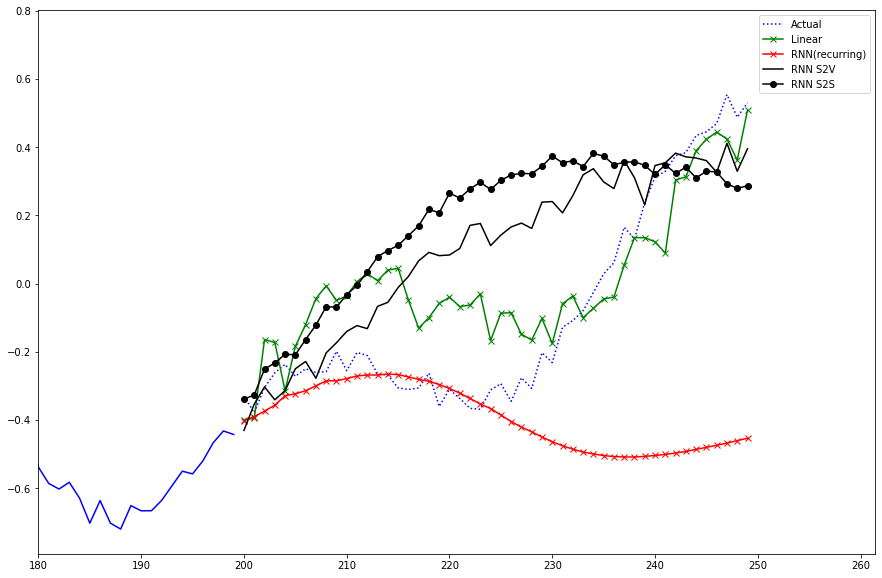

In [17]:
batch_id = 4
fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(X_test[batch_id], "b")

x_ticks = range(total_steps, total_steps + n_steps_ahead)

plt.plot(x_ticks, Y_test[batch_id], "b:", label="Actual")
plt.plot(x_ticks, y_linear[batch_id], "g", marker="x", label="Linear")
plt.plot(x_ticks, Y_rnn_plus_next[batch_id],
         "r", marker="x", label="RNN(recurring)")
plt.plot(x_ticks, Y_s2v[batch_id], "k", label="RNN S2V")
plt.plot(x_ticks, Y_s2s[batch_id, -1], "k",  marker="o", label="RNN S2S")
plt.xlim(180)

plt.legend()
plt.show()

 # Multi-step forecasting
 ## Option 1: Use one-step model several times in a row
 - Make the model predict the next value
 - Add value to the inputs (acting as if this predicted value had actually occurred)
 - Use the model again to predict the following value, and so on.
 Problems:
 - The predictions for the next time steps is always more accurate (erros accumulate).
 - Comparison with linear model